In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as colors
from matplotlib import collections
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

# Functions

In [2]:
def import_bulk_sim(filename, exp):
    # exp is either "opn" or "for" depending on if we want to analyse the snowpack in the open or in a forest

    
    mod = xr.open_dataset(filename)
    if exp == 'opn':
        swe = mod['SNOMA'].to_dataframe('swe')
        sd = mod['SNODP'].to_dataframe('sd')
        Ts = mod['TSNO_SURF'].to_dataframe('Ts')
        try:
            snow_can = mod['SNOMA'].to_dataframe('snow_can')
            sim = pd.concat([swe, sd, Ts, snow_can ], axis=1)
        except:
            sim = pd.concat([swe, sd, Ts ], axis=1)
        sim['den'] = sim.swe.values / sim.sd.values

        Thickness = mod['SNOMA_ML'].values / mod['SNODEN_ML'].values
        T_snow = mod['TSNOW_ML'].values
    elif exp == 'for':
        swe = mod['SNVMA'].to_dataframe('swe')
        sd = mod['SNVDP'].to_dataframe('sd')
        Ts = mod['TSNV_SURF'].to_dataframe('Ts')

        snow_can = mod['SNCMA'].to_dataframe('snow_can')
        sim = pd.concat([swe, sd, Ts, snow_can ], axis=1)
   
        sim['den'] = sim.swe.values / sim.sd.values

        Thickness = mod['SNOMAV_ML'].values / mod['SNODENV_ML'].values
        T_snow = mod['TSNOWV_ML'].values


    Tmean = []
    for i in range(len(T_snow)):

        T = T_snow[i][Thickness[i] > 0]
        thick = Thickness[i][Thickness[i] > 0]
        if len(T) > 0:
            Tmean.append(np.average(T, weights = thick))
        else:
            Tmean.append(np.nan)

    Tmean = np.array(Tmean)

    ci = 2.1e-3 # MJ/kg/C

    CC = (273.15-Tmean) * ci * sim['den'].values * sim['sd'].values

    sim['CC'] = CC

    return sim


In [3]:
def import_layers_sim(filename, exp):
    # exp is either "opn" or "for" depending on if we want to analyse the snowpack in the open or in a forest

    mod = xr.open_dataset(filename)
    
    if exp == 'opn':
        df = mod[['SNODEN_ML','SNOMA_ML','SNODP','SNODOPT_ML','TSNOW_ML','SNOTYPE_ML']].to_dataframe()
        df['Thickness'] = df[['SNODEN_ML','SNOMA_ML']].apply(lambda x : x[1] / x[0], axis = 1)
        df['SSA'] = df['SNODOPT_ML'].apply(lambda x : 6./(x*917) if x > 0 else np.nan)
    elif exp == 'for':
        df = mod[['SNODENV_ML','SNOMAV_ML','SNVDP','SNODOPTV_ML','TSNOWV_ML','SNOTYPEV_ML']].to_dataframe()
        df['Thickness'] = df[['SNODENV_ML','SNOMAV_ML']].apply(lambda x : x[1] / x[0], axis = 1)
        df['SSA'] = df['SNODOPTV_ML'].apply(lambda x : 6./(x*917) if x > 0 else np.nan)
        
    df.columns = ['rho_ML','SWE_ML','Depth','Dgrain_ML','T_ML','Gtype_ML','Thickness_ML','SSA_ML']
    return df    

In [4]:
## From proplotter (Snowtool)
# The list of SURFEX/MEPRA grain shapes associated to its common names

MEPRA_dict = {'PP': 0,      # fr
              'PP+DF': 1,   # fr_lb
              'DF': 2,      # lb
              'DF+RG': 3,   # lb_fin
              'DF+FC': 4,   # lb_ang
              'PPgp': 5,    # roul
              'RG': 6,      # fin
              'MF+RG': 7,   # fin_ar
              'RG+FC': 8,   # fin_ang
              'FC': 9,      # pl
              'FC+DH': 10,  # pl_gob
              'DH': 11,     # gob
              'MF': 12,     # gel
              'MF+DH': 13,  # gob_fon
              'MF+FC': 14   # ron_ang
              }

MEPRA_labels = ['PP', 'PP+DF', 'DF', 'DF+RG', 'DF+FC', 'PPgp', 'RG', 'MF+RG', 'RG+FC', 'FC', 'FC+DH', 'DH', 'MF', 'MF+DH', 'MF+FC']

coloring = {'PP': np.array([0, 255, 0]) / 255.0,
            'MM': np.array([255, 215, 0]) / 255.0,
            'DF': np.array([34, 139, 34]) / 255.0,
            'RG': np.array([255, 182, 193]) / 255.0,
            'FC': np.array([173, 216, 230]) / 255.0,
            'DH': np.array([0, 0, 255]) / 255.0,
            'SH': np.array([250, 0, 255]) / 255.0,
            'MF': np.array([255, 0, 0]) / 255.0,
            'MFcr': np.array([255, 255, 255]) / 255.0,
            'IF': np.array([0, 255, 255]) / 255.0,
            'NO': np.array([200, 200, 200]) / 255.0}

color_grain = {MEPRA_dict['PP']: coloring['PP'],
               MEPRA_dict['PP+DF']: 0.5 * (coloring['PP'] + coloring['DF']),
               MEPRA_dict['DF']: coloring['DF'],
               MEPRA_dict['DF+RG']: 0.5 * (coloring['DF'] + coloring['RG']),
               MEPRA_dict['DF+FC']: 0.5 * (coloring['DF'] + coloring['FC']),
               MEPRA_dict['PPgp']: [0, 0, 0],
               MEPRA_dict['RG']: coloring['RG'],
               MEPRA_dict['MF+RG']: 0.5 * (coloring['MF'] + coloring['RG']),
               MEPRA_dict['RG+FC']: 0.5 * (coloring['RG'] + coloring['FC']),
               MEPRA_dict['FC']: coloring['FC'],
               MEPRA_dict['FC+DH']: 0.5 * (coloring['FC'] + coloring['DH']),
               MEPRA_dict['DH']: coloring['DH'],
               MEPRA_dict['MF']: coloring['MF'],
               MEPRA_dict['MF+DH']: 0.5 * (coloring['MF'] + coloring['DH']),
               MEPRA_dict['MF+FC']: 0.5 * (coloring['MF'] + coloring['FC'])}

grain_colormap = LinearSegmentedColormap.from_list("custom", [[i / 14., color_grain[i]] for i in range(15)])


In [5]:
def get_season_profile(df, variable, nlayers=20, hours_snowpits=6):
    time = df.index.get_level_values('time').unique()

    # Look for the first time when a snowpit is outputted
    time_snowpits = True
    i = 0
    while time_snowpits:
        time_hour = time[i].hour
        if time_hour // hours_snowpits:
            time_snowpits = False
        else:
            i += 1

    time = time[i::hours_snowpits]

    dz = df['Thickness_ML'].values
    dz = np.reshape(dz, (-1,nlayers))[i::hours_snowpits,:]
    dz[np.isnan(dz)] = 0

    value = df[variable].values
    value = np.reshape(value, (-1,nlayers))[i::hours_snowpits,:]
    value[np.isnan(value)] = 0

    top_y = np.cumsum(dz[:, ::-1], axis=1)[:, ::-1].ravel()
    bottom_y = top_y - dz.ravel()

    left_x = np.ones(shape=dz.shape, dtype='int')
    left_x = np.cumsum(left_x, axis=0).ravel()
    right_x = left_x - 1

    vertices = np.zeros(shape=(right_x.shape[0], 4, 2))
    vertices[:, 0, 0] = right_x
    vertices[:, 0, 1] = bottom_y
    vertices[:, 1, 0] = right_x
    vertices[:, 1, 1] = top_y
    vertices[:, 2, 0] = left_x
    vertices[:, 2, 1] = top_y
    vertices[:, 3, 0] = left_x
    vertices[:, 3, 1] = bottom_y

    vertices = vertices[(dz > 0).ravel()]

    return time, vertices, value, dz

In [6]:
def format_ticks(x, pos):
    x = int(x)
    x = max(min(len(time) - 1, x), 0)
    if hasattr(time[0], 'strftime'):
        return time[x].strftime('%Y-%m-%d')
    else:
        return time[x]

In [7]:
def pit_sim(df, time, variable):
    
    df = df.loc[time] # Select the time wanted
    
    depth = df.loc[0, "Depth"]
    nl = len(df)
    for n in range(nl):  # Determine the bottom and top heights of each layer
        if n > 0:
            df.loc[n, "height_top"] = depth - df.loc[: n - 1, "Thickness_ML"].sum()
            df.loc[n, "height_bot"] = depth - df.loc[:n, "Thickness_ML"].sum()
        else:
            df.loc[n, "height_top"] = depth
            df.loc[n, "height_bot"] = depth - df.loc[n, "Thickness_ML"]

    # Get the height and density for the plot for the simulation profile
    df = df[df["SWE_ML"] > 0]
    A = df["height_top"].values
    B = df["height_bot"].values
    hgt = np.dstack([A, B]).flatten()
    hgt_norm = hgt / depth

    A = df[variable].values
    B = df[variable].values
    variable_ML = np.dstack([A, B]).flatten()

    return hgt, hgt_norm, variable_ML

In [8]:
def plot_2Dprofile(ax, times, df_sim, variable):

    n = len(times) 
    
    if variable == 'Gtype_ML':
        cmap = grain_colormap
        bounds = np.linspace(-0.5, 14.5, 16)
        norm = BoundaryNorm(bounds, cmap.N)
    else :
        cmap = 'jet'

    max_height = 0
    for j, time in enumerate(times):
        
        Type = df_sim.loc[time][variable].values
        Type[np.isnan(Type)] = np.nan
        
        height_max = 0
    
        hgt, hgt_norm, value = pit_sim(df_sim, time, variable)
        
        hgt_bot = hgt[1::2]
        hgt_top = hgt[::2]

        max_height = max([max_height,max(hgt_top)])
    
        # Loop over data points; create box from snowtype  at each layer
        layers_sim = [Rectangle((j/n, h_bot), (j+1)/n - j/n, h_top-h_bot,edgecolor=None) for h_bot, h_top in zip(list(hgt_bot),list(hgt_top))]
    
        height_max = np.max([height_max, np.max(hgt_top)])
    
        # Create patch collection with specified colour/alpha
        if variable == 'Gtype_ML':
            pc = PatchCollection(layers_sim, array = Type, cmap=cmap, norm=norm)#, edgecolor='black')
        else :
            pc = PatchCollection(layers_sim, array = Type, cmap=cmap)#, edgecolor='black')


        # Add collection to axes
        ax.add_collection(pc)

        plt.axvline(j/n, color = 'grey')
        
    ax.set_xticks(np.linspace(0.5/n, 1.-0.5/n, n), times, rotation = 45)
    ax.set_xlim(0,1)
    ax.set_ylim(0,max_height + 0.1)
    cbar = plt.colorbar(pc, ax=ax)

    if variable == 'Gtype_ML':
        labels = MEPRA_labels
        cbar.set_ticks(np.arange(np.shape(labels)[0]))
        cbar.ax.set_yticklabels(labels)
    else :
        cbar.ax.set_title(variable)


    return (pc, height_max)



# Paths output folder/file

In [9]:
path_output = './output'

In [10]:
file_svs2 = os.path.join(path_output,  'out_svs2.nc')

# Import bulk snow properties

In [11]:
exp = 'opn' # "opn" or "for" if you want to look at the properties of the snowpack in the open or in the forest, respectively

df_bulk = import_bulk_sim(file_svs2, exp)

/var/tmp/pbs.632270924.ppp5pbs-001-ib/ipykernel_3416702/426474424.py:15: RuntimeWarning: invalid value encountered in divide
  sim['den'] = sim.swe.values / sim.sd.values


In [12]:
df_bulk.head()

,swe,sd,Ts,snow_can,den,CC
time,,,,,,
1999-10-01 00:00:00,0.0,0.0,273.16,0.0,NaN,NaN
1999-10-01 01:00:00,0.0,0.0,273.16,0.0,NaN,NaN
1999-10-01 02:00:00,0.0,0.0,273.16,0.0,NaN,NaN
1999-10-01 03:00:00,0.0,0.0,273.16,0.0,NaN,NaN
1999-10-01 04:00:00,0.0,0.0,273.16,0.0,NaN,NaN


# Import snow layer properties

In [13]:
exp = 'opn' # "opn" or "for" if you want to look at the properties of the snowpack in the open or in the forest, respectively
df_layer = import_layers_sim(file_svs2, exp)

In [14]:
df_layer.head()

# rho_ML :  densityof each layer (kg/m3)
# SWE_ML :  SWE of each layer (mm)
# Depth :  bulk snow depth (cm)
# Dgrain_ML : optical diameter of grains of each layer (m)
# T_ML : Temperature of each layer (C)
# Gtype_ML : Grain type of each layer (-)
# Thickness_ML : Thickness of each layer (m)
# SSA_ML : SSA of each layer (m2/kg)


rho_ML  SWE_ML  Depth  Dgrain_ML    T_ML      Gtype_ML  \
time       snow_layer                                                           
1999-10-01 0             50.0     0.0    0.0        0.0  273.16  1.000000e+20   
           1             50.0     0.0    0.0        0.0  273.16  1.000000e+20   
           2             50.0     0.0    0.0        0.0  273.16  1.000000e+20   
           3             50.0     0.0    0.0        0.0  273.16  1.000000e+20   
           4             50.0     0.0    0.0        0.0  273.16  1.000000e+20   

                       Thickness_ML  SSA_ML  
time       snow_layer                        
1999-10-01 0                    0.0     NaN  
           1                    0.0     NaN  
           2                    0.0     NaN  
           3                    0.0     NaN  
           4                    0.0     NaN

# Plot bulk properties

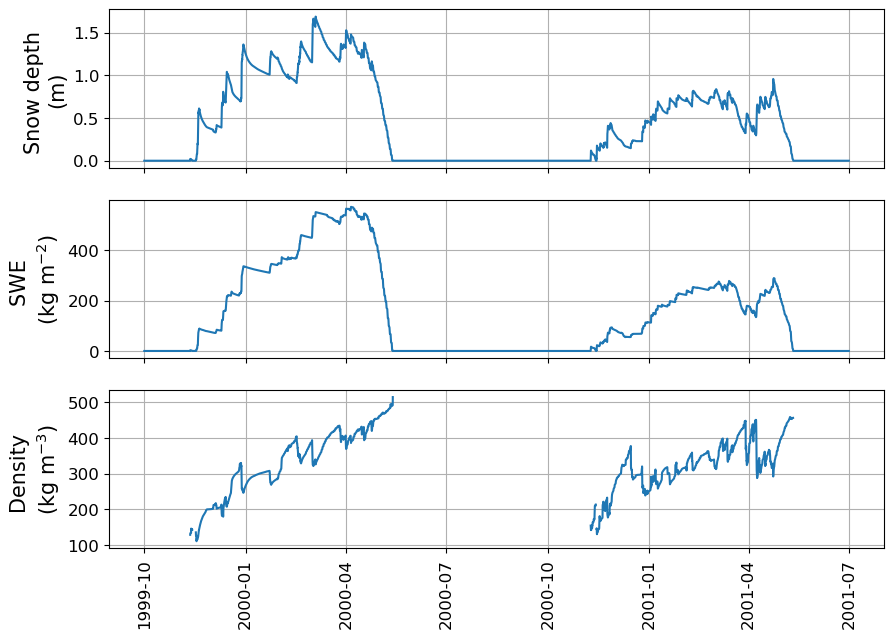

In [15]:
fig, ax = plt.subplots(nrows = 3,sharex = 'all', figsize = (10,7))

plt.sca(ax[0]) # sd
plt.plot(df_bulk.index, df_bulk.sd,)

plt.ylabel('Snow depth \n(m)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid()

plt.sca(ax[1]) # SWE
plt.plot(df_bulk.index, df_bulk.swe)

plt.ylabel('SWE \n(kg m$^{-2}$)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid()

plt.sca(ax[2]) # density
plt.plot(df_bulk.index, df_bulk.den)
plt.ylabel('Density \n(kg m$^{-3}$)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.grid()
plt.show()

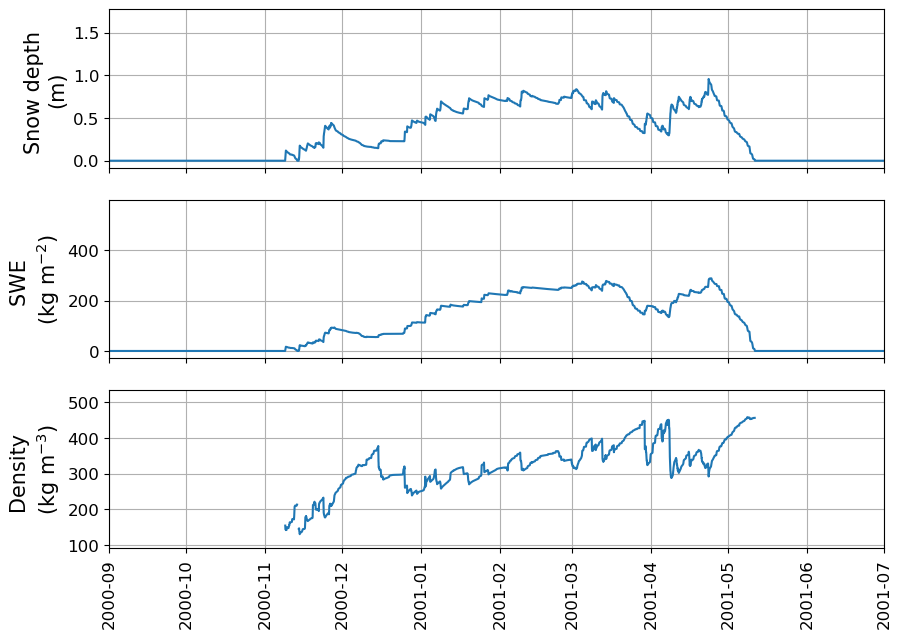

In [16]:
# Same graph but between two chosen dates
time_start = datetime.datetime(2000,9,1)
time_end = datetime.datetime(2001,7,1)


fig, ax = plt.subplots(nrows = 3,sharex = 'all', figsize = (10,7))

plt.sca(ax[0]) # sd
plt.plot(df_bulk.index, df_bulk.sd,)

plt.ylabel('Snow depth \n(m)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid()

plt.sca(ax[1]) # SWE
plt.plot(df_bulk.index, df_bulk.swe)

plt.ylabel('SWE \n(kg m$^{-2}$)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid()

plt.sca(ax[2]) # density
plt.plot(df_bulk.index, df_bulk.den)
plt.ylabel('Density \n(kg m$^{-3}$)', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.grid()
plt.xlim(time_start, time_end)

plt.show()

# Plot grain type time series

In [17]:
variable = 'Gtype_ML'

time, vertices, Gtype, dz = get_season_profile(df_layer, variable,  nlayers=20, hours_snowpits=6) # If the "time" output has another name, it should be changed in the fonction format_ticks()
# The two inputs 'nlayers' and 'hours_snowpits' to the function "get_season_profile" must correspond to the 'nsl' and 'nprofile_day' (converted to hours) chosen in the MESH_parameters file

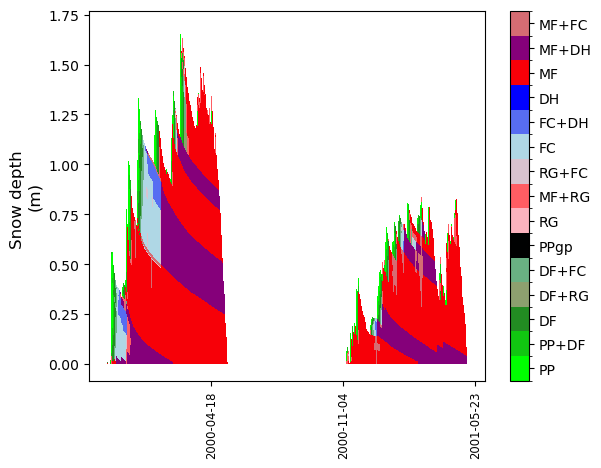

In [18]:
# This cell is specific to plotting grain type


cmap = grain_colormap
bounds = np.linspace(-0.5, 14.5, 16)
norm = BoundaryNorm(bounds, cmap.N)
vmin = -0.5
vmax = 14.5
extend = 'neither'


plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=Gtype[(dz > 0)].ravel(),
                                    cmap=cmap, norm=norm, edgecolors='none')
rect.set_clim(vmin, vmax)
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax, extend=extend)

labels = MEPRA_labels
cbar.set_ticks(np.arange(np.shape(labels)[0]))
cbar.ax.set_yticklabels(labels)


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)
plt.show()


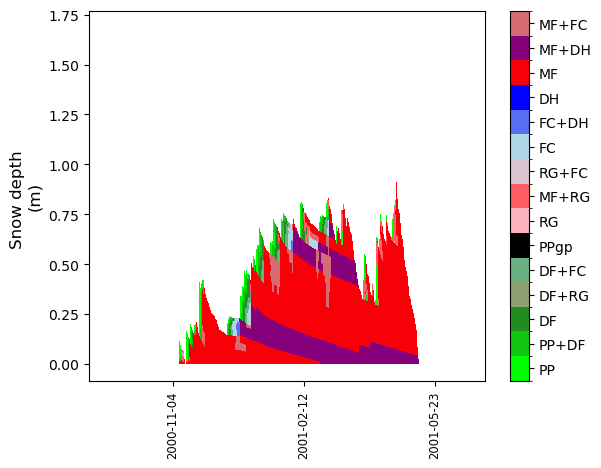

In [19]:
# Same plot but between two chosen dates
time_start = datetime.datetime(2000,9,1)
time_end = datetime.datetime(2001,7,1)

cmap = grain_colormap
bounds = np.linspace(-0.5, 14.5, 16)
norm = BoundaryNorm(bounds, cmap.N)
vmin = -0.5
vmax = 14.5
extend = 'neither'


plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=Gtype[(dz > 0)].ravel(),
                                    cmap=cmap, norm=norm, edgecolors='none')
rect.set_clim(vmin, vmax)
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax, extend=extend)

labels = MEPRA_labels
cbar.set_ticks(np.arange(np.shape(labels)[0]))
cbar.ax.set_yticklabels(labels)


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)

x = np.argwhere( (time >= time_start) & (time <= time_end)).flatten()
plt.xlim(x[0], x[-1])
plt.show()


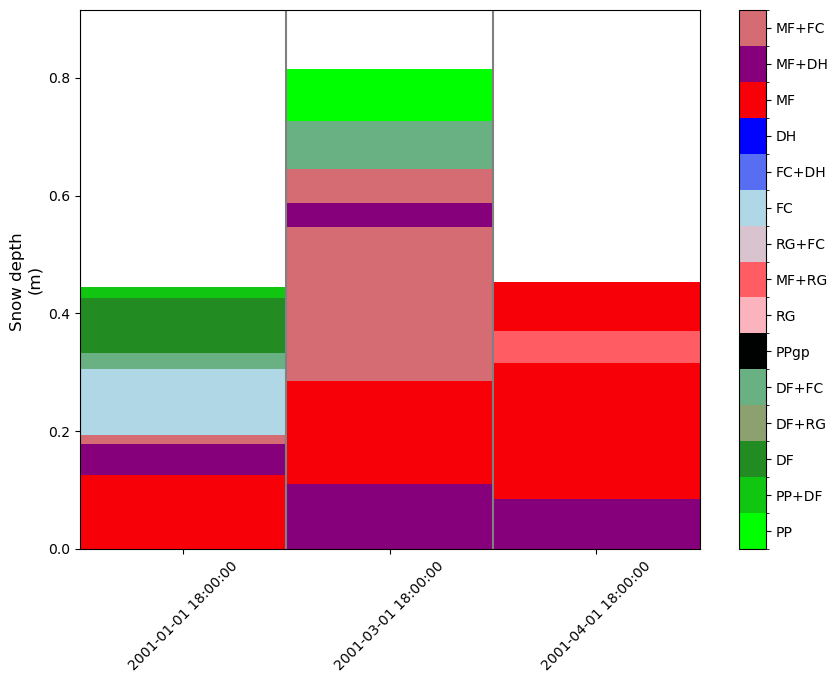

In [20]:
time = [datetime.datetime(2001,1,1,18,0), datetime.datetime(2001,3,1,18,0), datetime.datetime(2001,4,1,18,0)]

fig, ax = plt.subplots(figsize = (10,7))
plot_2Dprofile(ax, time, df_layer, variable)
plt.ylabel('Snow depth \n(m)', fontsize = 12)
plt.show()

# Plot any other layer property time series

In [21]:
variable = 'rho_ML'
# rho_ML :  density of each layer (kg/m3)
# SWE_ML :  SWE of each layer (mm)
# Dgrain_ML : optical diameter of grains of each layer (m)
# T_ML : Temperature of each layer (C)
# SSA_ML : SSA of each layer (m2/kg)

time, vertices, values, dz = get_season_profile(df_layer, variable) # If the "time" output has another name, it should be changed in the fonction format_ticks()


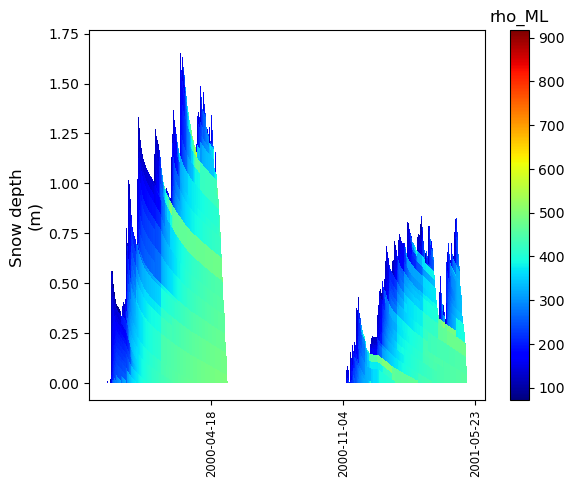

In [22]:
# This cell is specific to plotting grain type


cmap = 'jet'
extend = 'neither'


plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=values[(dz > 0)].ravel(),
                                    cmap=cmap, edgecolors='none')
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax)
cbar.ax.set_title(variable)


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)
plt.show()

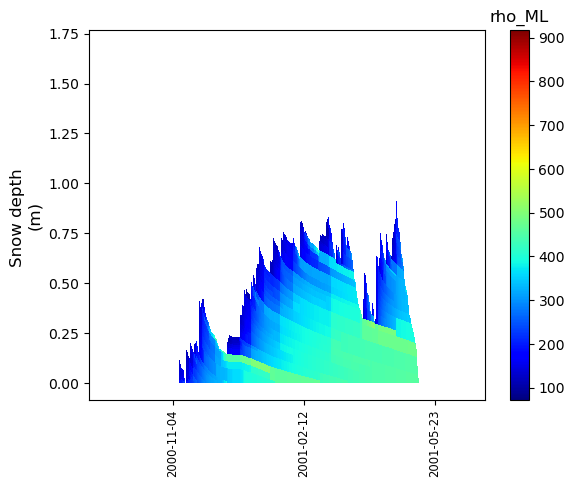

In [23]:
# Between two chosen dates
time_start = datetime.datetime(2000,9,1)
time_end = datetime.datetime(2001,7,1)


cmap = 'jet'
extend = 'neither'


plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=values[(dz > 0)].ravel(),
                                    cmap=cmap, edgecolors='none')
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax)
cbar.ax.set_title(variable)


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)
x = np.argwhere( (time >= time_start) & (time <= time_end)).flatten()
plt.xlim(x[0], x[-1])
plt.show()

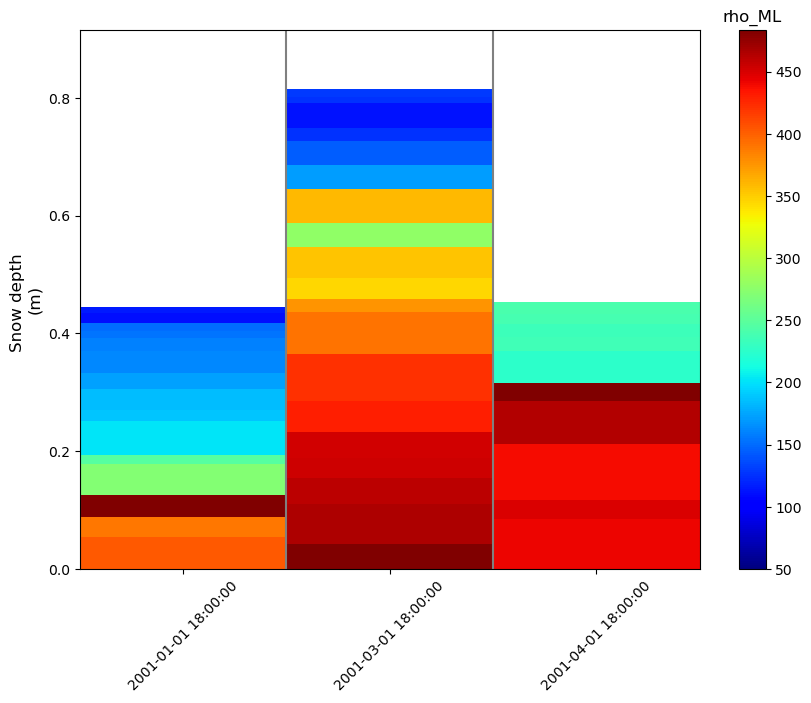

In [24]:
time = [datetime.datetime(2001,1,1,18,0), datetime.datetime(2001,3,1,18,0), datetime.datetime(2001,4,1,18,0)]

fig, ax = plt.subplots(figsize = (10,7))
plot_2Dprofile(ax, time, df_layer, variable)
plt.ylabel('Snow depth \n(m)', fontsize = 12)
plt.show()

# Plot vertical profile at a chosen date

In [25]:
# Vertical layer properties are outputted every 6h, so choose an hour within [0,6,12,18]

time = datetime.datetime(2001,1,1,18,0)

variable = 'rho_ML'
# rho_ML :  density of each layer (kg/m3)
# SWE_ML :  SWE of each layer (mm)
# Dgrain_ML : optical diameter of grains of each layer (m)
# T_ML : Temperature of each layer (C)
# SSA_ML : SSA of each layer (m2/kg)

hgt, hgt_norm, value = pit_sim(df_layer, time, variable)


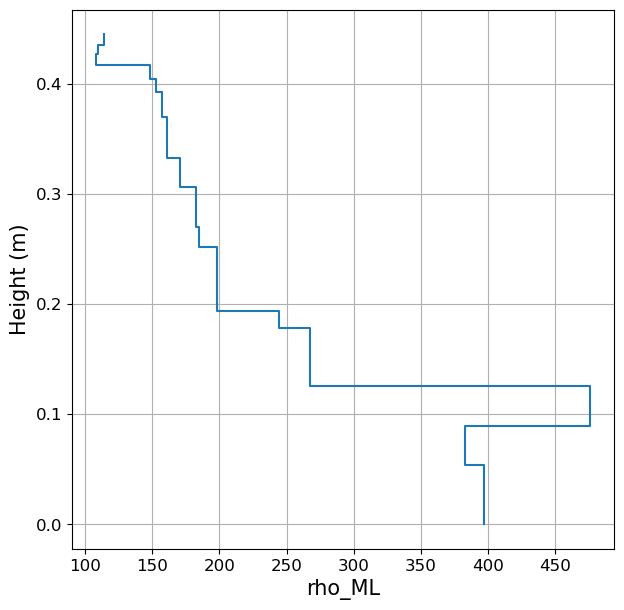

In [26]:
# Plot CROCUS simulation density profile
plt.figure(figsize=(7,7))

plt.plot(value, hgt)

plt.grid()
plt.ylabel("Height (m)", fontsize=15)
plt.xlabel(variable, fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Calculate gradient of temperature

In [27]:
variable = 'T_ML'
# rho_ML :  density of each layer (kg/m3)
# SWE_ML :  SWE of each layer (mm)
# Dgrain_ML : optical diameter of grains of each layer (m)
# T_ML : Temperature of each layer (C)
# SSA_ML : SSA of each layer (m2/kg)

time, vertices, Temp, dz = get_season_profile(df_layer, variable) # If the "time" output has another name, it should be changed in the fonction format_ticks()



In [28]:
gradT = np.zeros(np.shape(Temp)) + np.nan

for i in range(np.shape(Temp)[0]):
    if np.where(dz[i,:] != 0)[0].size > 0:
        max_layer = np.where(dz[i,:] != 0)[0].max()
        
        gradT[i,max_layer] = np.abs(Temp[i,max_layer] - Temp[i,max_layer-1])*2. / (dz[i,max_layer-1] + dz[i,max_layer]) 
        
        gradT[i,0] = np.abs(Temp[i,1] - Temp[i,0])*2. / (dz[i,0] + dz[i,1]) 
        
        for j in range(1, max_layer):
            gradT[i,j] = np.abs(Temp[i,j+1] - Temp[i,j-1])*2. / (dz[i,j-1] + dz[i,j+1]+ dz[i,j]*2) 

        

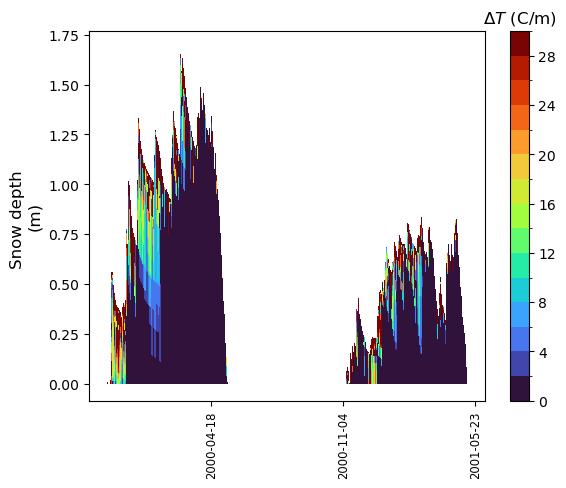

In [29]:
# This cell is specific to plotting grain type

cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,30,16)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=gradT[(dz > 0)].ravel(),
                                    edgecolors='none', cmap=cmap, norm=norm)
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax)
cbar.ax.set_title(r'$\Delta T$ (C/m)')


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)
plt.show()

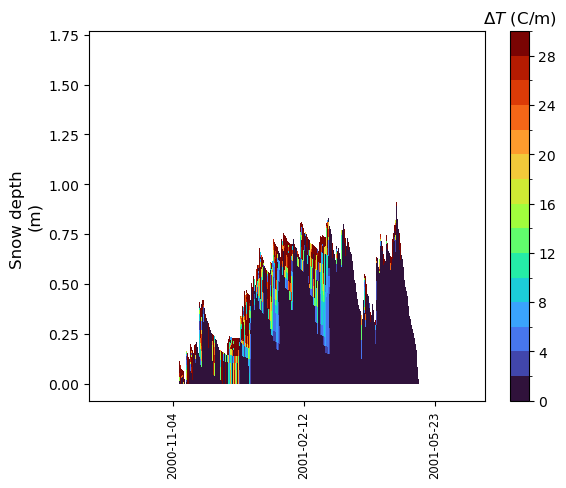

In [30]:
# Between two chosen dates
time_start = datetime.datetime(2000,9,1)
time_end = datetime.datetime(2001,7,1)


cmap = plt.cm.turbo  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,30,16)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure()

ax = plt.gca()

rect = collections.PolyCollection(vertices, array=gradT[(dz > 0)].ravel(),
                                    edgecolors='none', cmap=cmap, norm=norm)
ax.add_collection(rect)
ax.autoscale_view()

cbar = plt.colorbar(rect, ax=ax)
cbar.ax.set_title(r'$\Delta T$ (C/m)')


formatter = ticker.FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.setp(ax.xaxis.get_majorticklabels(), size='small')
plt.xticks(rotation = 90)

plt.ylabel('Snow depth \n(m)', fontsize = 12)
x = np.argwhere( (time >= time_start) & (time <= time_end)).flatten()
plt.xlim(x[0], x[-1])
plt.show()